<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) a deep network,
(2) method of calculating accuracy, 
(3) images that show the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 20% Proper implementation of train/test set accuracy measure
* 20% Tidy visualizations of loss of your dense predictor during training
* 20% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**

* Watch tutorial

**DONE:**

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

___

Implement your network topology

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

You can simplify the implementation of this lab by padding the feature maps as they pass through each convolution. This will make the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper. 

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

**TODO:**

* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose
* Answer Question / Reflect on simplest network with the desired properties

**DONE:**


___
The intention of this lab is to learn how to make deep neural nets. We'll help you with the implementation of Dataset.
This code will download the dataset for you so that you are ready to use it and focus on network
implementation, losses and accuracies.

Here's an example architexture: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py


In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [26]:
import time

In [2]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=256, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [3]:
# You'll probably want a function or something to test input / output sizes of the ConvTranspose2d layer


In [52]:
# Since you will be using the output of one network in two places(convolution and maxpooling),
# you can't use nn.Sequential.
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layer.

# TODO: You need to change this to fit the UNet structure!!!
class CancerDetection(nn.Module):
  def __init__(self): # CancerDetection constructor
    # You always need to use super to call nn.Module's init function when creating a class that inherits nn.Module.
    super(CancerDetection, self).__init__()
    
    # Always initialize your layers in the init function.
   
    self.conv1 = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(64,64,kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(128,128,kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(128,256,kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(256,256,kernel_size=3, stride=1, padding=1)
    self.conv7 = nn.Conv2d(256,512,kernel_size=3, stride=1, padding=1)
    self.conv8 = nn.Conv2d(512,512,kernel_size=3, stride=1, padding=1)
    self.conv9 = nn.Conv2d(512,1024,kernel_size=3, stride=1, padding=1)
    self.conv10 = nn.Conv2d(1024,1024,kernel_size=3, stride=1, padding=1)
    self.conv11 = nn.Conv2d(1024,512,kernel_size=3, stride=1, padding=1)
    self.conv12 = nn.Conv2d(512,512,kernel_size=3, stride=1, padding=1)
    self.conv13 = nn.Conv2d(512,256,kernel_size=3, stride=1, padding=1)
    self.conv14 = nn.Conv2d(256,256,kernel_size=3, stride=1, padding=1)
    self.conv15 = nn.Conv2d(256,128,kernel_size=3, stride=1, padding=1)
    self.conv16 = nn.Conv2d(128,128,kernel_size=3, stride=1, padding=1)
    self.conv17 = nn.Conv2d(128,64,kernel_size=3, stride=1, padding=1)
    self.conv18 = nn.Conv2d(64,64,kernel_size=3, stride=1, padding=1)
    self.conv19 = nn.Conv2d(64,2,kernel_size=3, stride=1, padding=1)

    

    self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
    self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
    self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
    self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)



    
 
  def forward(self, input): # nn.Module sets up a hook that calls forward when you "call" the module object: net(x) calls net.forward(x)
    n, c, h, w = input.size()

    o1 = F.relu(self.conv1(input))
    o2 = F.relu(self.conv2(o1)) # cat w/ conv17
    o3 = F.relu(self.conv3(F.max_pool2d(o2,kernel_size=2)))
    o4 = F.relu(self.conv4(o3)) # cat w/ conv15
    o5 = F.relu(self.conv5(F.max_pool2d(o4,kernel_size=2)))
    o6 = F.relu(self.conv6(o5)) # cat w/ conv13
    o7 = F.relu(self.conv7(F.max_pool2d(o6,kernel_size=2)))
    o8 = F.relu(self.conv8(o7)) # cat w/ conv11
    o9 = F.relu(self.conv9(F.max_pool2d(o8,kernel_size=2)))
    o10 = F.relu(self.conv10(o9))
    u1 = self.up1(o10)
    o11 = F.relu(self.conv11(torch.cat((u1,o8),dim=1)))
    o12 = F.relu(self.conv12(o11))
    u2 = self.up2(o12)
    o13 = F.relu(self.conv13(torch.cat((u2,o6),dim=1)))
    o14 = F.relu(self.conv14(o13))
    u3 = self.up3(o14)
    o15 = F.relu(self.conv15(torch.cat((u3,o4),dim=1)))
    o16 = F.relu(self.conv16(o15))
    u4 = self.up4(o16)
    o17 = F.relu(self.conv17(torch.cat((u4,o2),dim=1)))
    o18 = F.relu(self.conv18(o17))
    o19 = F.relu(self.conv19(o18))



    return o19.float()

  




In [12]:
# Create your datasets, dataloaders and neural network as you have before
# Tip: Pass shuffle=True to constructor for training dataloader to automatically shuffle training data each epoch. You can shuffle the validation loader, but you don't need to.
train_dataset = CancerDataset('/tmp/cancer', train=True)
val_dataset = CancerDataset('/tmp/cancer', train=False)


gc.collect()
print(torch.cuda.memory_allocated() / 1e9)

0.0


In [226]:
# This is what was talked about in the video for memory management

def scope():
  try:
    #your code for calling dataset and dataloader
    
    
    #for epochs:
    # Call your model, figure out loss and accuracy
    model = CancerDetection()
    model.cuda()
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_loader = DataLoader(train_dataset,
                              batch_size=5,
                              pin_memory=True,
                              num_workers=2,
                              shuffle=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=5,
                            num_workers=2,
                            pin_memory=True)
    
    accuracies = []
    losses = []
    validations = []
    val_accuracies = []
    preds = []
    #batch_time = []
    #val_time = []

    for epoch in range(3):
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        y_truth = y_truth.long()
        x = x.cuda()
        y_truth = y_truth.cuda()


        optimizer.zero_grad()
        y_hat = model(x)
        # print(y_hat.type(), y_truth.type())

        loss = objective(y_hat, y_truth)

        loss.backward()

        losses.append(loss.item()) 
        # batch_time.append(time.time())
        accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
        accuracies.append(accuracy)
        mem = torch.cuda.memory_allocated() / 1e9
        loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.2f}'.format(epoch, loss, accuracy, mem))
        loop.update(1)

        optimizer.step()

        if batch %500 == 0:
          
          vals = []
          accs = []
          for x, y in val_loader:
            y = y.long()
            x,y = x.cuda(), y.cuda()
            y_hat_val = model(x)
            
            vals.append(objective(y_hat_val,y).item())
            val = np.mean(vals)
            try:
              acc = np.mean((torch.softmax(y_hat_val, 1).argmax(1) == y.long()).float()) #.item()
              accs.append(acc)

            except:
              pass
            
          
          # print(accs[0].size(),accs[-1].size())

          # mean_acc = np.mean(accs)
          mean_val = np.mean(vals)
          validations.append((len(losses),val))
          #val_accuracies.append((len(losses),acc))
          """
          val = np.mean([objective(model(x.cuda()), y.long().cuda()).item()
          for x, y in val_loader])
          validations.append((len(losses),val))
          val_accuracy = np.mean([(torch.softmax(model(x.cuda()), 1).argmax(1) == y.cuda()).float().mean() for x, y in val_loader])
          val_accuracies.append((len(losses),val_accuracy))
          """
          # val_time.append(time.time())
      # gc.collect()
      

      loop.close()
      gc.collect()
    return validations, accuracies, losses, model, preds
  except:
    __ITB__()    
validations, accuracies, losses, model, preds = scope()


0.0


I tried part 3, but the code messed up my training. oof.


How to save memory: 


*   model.cuda() not model = model.cuda()
*   force gc to collect: gc.collect()
*   unhandled exceptions cause memory leak -- try/except block the model/dataset creation -- in except 
*   put it all in a function scope() which will help limit teh amount of memory that persists 






In [ ]:
except:
  __ITB__()

In [220]:
len(preds)

5

In [221]:
preds

[tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 


___

### Part 2

Plot performance over time

Please generate two plots:

 One that shows loss on the training and validation set as a function of training time. 

 One that shows accuracy on the training and validation set as a function of training time. 

 Make sure your axes are labeled!

**TODO:**

* Plot training/validation loss as function of training time (not epochs)
* Plot training/validation accuracy as function of training time (not epochs)

**DONE:**



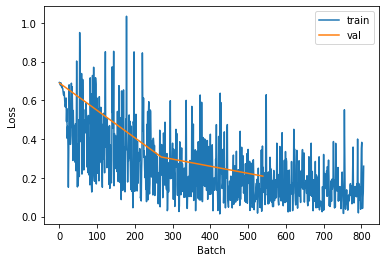

In [227]:
# Your plotting code here
a, b = zip(*validations)
plt.plot(losses, label="train")
plt.plot(a,b,label="val")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [173]:
plt.savefig("test.png")

<Figure size 432x288 with 0 Axes>

In [108]:
accuracies[0].item()

0.17327271401882172

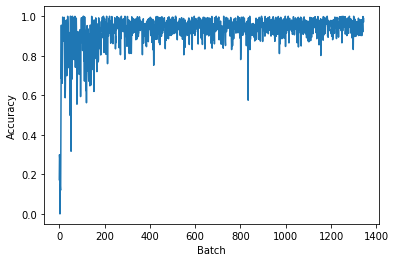

In [112]:
a = [accuracies[i].item() for i in range(len(accuracies))]

plt.plot(a,label="Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

___

### Part 3

Generate at least 5 predictions on the pos_test_000072.png image and display them as images. These predictions should be made at a reasonable interval (e.g. every epoch). 

You can load this image from the file pos_test_000072.png, or you can get it from the dataset object. It is item 172 of the validation dataset.
You can print both the data instance (x) and the ground-truth label (y_hat) to see how well your network predicts on that instance.

To do this, calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent areas
the network considers cancerous.

**TODO:**

**DONE:**



In [176]:
# Code for testing prediction on an image
print(val_dataset[171])
x, target = val_dataset[171]
print(x.size())
print(target.size())
# pred = model(x)

# print(pred, target)


(tensor([[[0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         ...,
         [0.8392, 0.8510, 0.8353,  ..., 0.9569, 0.9647, 0.9647],
         [0.8392, 0.8588, 0.8549,  ..., 0.9647, 0.9647, 0.9647],
         [0.8314, 0.8549, 0.8667,  ..., 0.9647, 0.9647, 0.9647]],

        [[0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         ...,
         [0.8000, 0.8196, 0.8039,  ..., 0.9647, 0.9647, 0.9647],
         [0.8000, 0.8235, 0.8196,  ..., 0.9647, 0.9647, 0.9647],
         [0.8000, 0.8275, 0.8392,  ..., 0.9647, 0.9647, 0.9647]],

        [[0.9569, 0.9569, 0.9647,  ..., 0.9647, 0.9569, 0.9569],
         [0.9569, 0.9569, 0.9647,  ..., 0.9647, 0.9569, 0.9569],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9569, 0

In [177]:
x.unsqueeze(dim=0).size()

torch.Size([1, 3, 256, 256])

In [178]:
output = model(x.unsqueeze(dim=0).cuda()).cpu()

In [191]:
print(output)
im = output


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<CopyBackwards>)


In [192]:
im = np.transpose(im.squeeze().detach().numpy())

In [195]:
im.shape

(256, 256, 2)

In [197]:
im = np.argmax(im)

ValueError: ignored

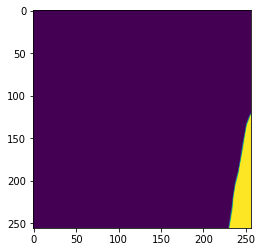

In [217]:
plt.imshow(target)
plt.imshow(np.transpose(x,(1,2)))

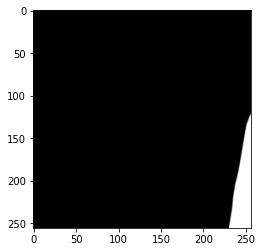

In [207]:
plt.imshow(target, cmap='gray')


In [202]:
plt.savefig("test.png")

<Figure size 432x288 with 0 Axes>